In [12]:
set more off
global fd "C:\Users\suraj.kumar\Dropbox\NKPC Estimation State Panel data"

In [13]:
// Loading the data
use "$fd/data/dta_files/cpi_allIndia_sa.dta", clear
// describe

// Setting the time parameter
format mdate %tm
tsset mdate

// Transforming variables
cap drop lfood lcore lfuel lcpi 

gen food = log(cpi_Food_sa)
gen core = log(cpi_Core_sa)
gen fuel = log(cpi_Fuel_sa)
gen cpi = log(cpi_All_sa)


// Specying options for regression
local ar = 12
local ma = 12
local hmax = 24




        time variable:  mdate, 2011m1 to 2022m11
                delta:  1 month










In [14]:
foreach x in cpi food fuel core{
    forvalue h = 0/`hmax'{
        // qui gen `x'_mom_`h' = f`h'.`x'-l1.f`h'.`x'
        qui gen pi`x'_`h' = f`h'.`x'-l12.f`h'.`x'
    }
    * Creating simple inflation variable also apart from the subscripts 
    qui gen pi`x' = `x'-l12.`x'
    // qui gen `x'_mom = `x'-l1.`x'
}


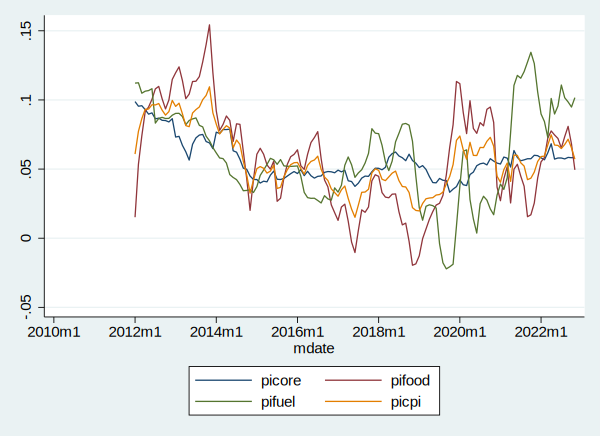

In [4]:
// Sample Plots
tsline picore pifood pifuel picpi

#### 1. Local Projection Estimation

In [15]:
* Running Core inflation on lags of Food and Fuel Inflation
eststo clear
qui cap drop b_core_food u_core_food d_core_food b_core_fuel u_core_fuel d_core_fuel horizons Zero

* Initializing variables to store the regression output
qui gen horizons = _n-1 if _n <= `hmax'
qui gen Zero = 0 if _n <= `hmax'
qui gen b_core_food = .
qui gen u_core_food = .
qui gen d_core_food = .
qui gen b_core_fuel = .
qui gen u_core_fuel = .
qui gen d_core_fuel = .

forv h = 0/`hmax'{
    
    ** Regression 1
    * on inflation
    qui reg picore_`h' l(0/`ma').pifood l(0/`ma').pifuel l(1/`ar').picore     
    
    // Saving the Food Coefficient results
    qui replace b_core_food = _b[pifood]  if _n == `h'+1
    qui replace u_core_food = _b[pifood] + 1.96*_se[pifood] if _n == `h'+1
    qui replace d_core_food = _b[pifood] - 1.96*_se[pifood] if _n == `h'+1
    
    // Saving the Fuel Coefficient Reults
    qui replace b_core_fuel = _b[pifuel]  if _n == `h'+1
    qui replace u_core_fuel = _b[pifuel] + 1.96*_se[pifuel] if _n == `h'+1
    qui replace d_core_fuel = _b[pifuel] - 1.96*_se[pifuel] if _n == `h'+1
    qui eststo
}

// Saving the regression output
// qui esttab using "$fd/Results/regression/lp_core_on_food_fuel_dgcis_import_all.html", html replace

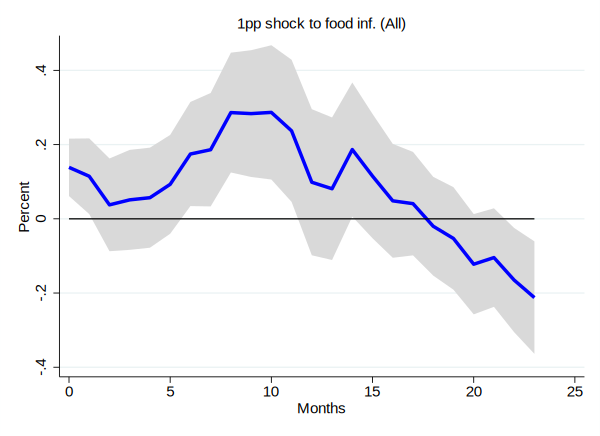

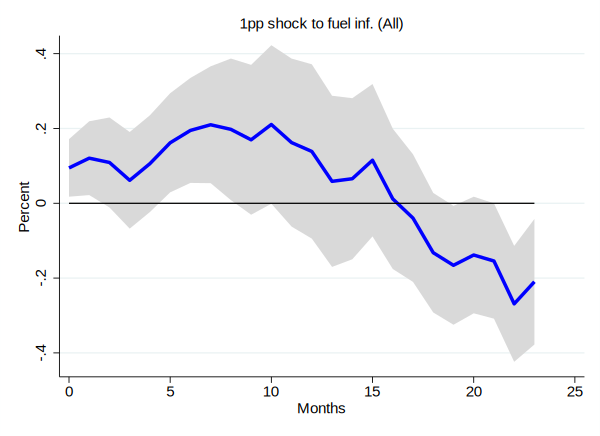

In [16]:
// Food Response
twoway ///
(rarea u_core_food d_core_food horizons,  ///
fcolor(gs13) lcolor(gs13) lw(none) lpattern(solid)) ///
(line b_core_food horizons, lcolor(blue) ///
lpattern(solid) lwidth(thick)) ///
(line Zero horizons, lcolor(black)), legend(off) ///
title("1pp shock to food inf. (All)", color(black) size(medsmall)) ///
ytitle("Percent", size(medsmall)) xtitle("Months", size(medsmall)) ///
graphregion(color(white)) plotregion(color(white)) 
qui gr rename fig_core_food, replace


// Fuel Response
twoway ///
(rarea u_core_fuel d_core_fuel horizons,  ///
fcolor(gs13) lcolor(gs13) lw(none) lpattern(solid)) ///
(line b_core_fuel horizons, lcolor(blue) ///
lpattern(solid) lwidth(thick)) ///
(line Zero horizons, lcolor(black)), legend(off) ///
title("1pp shock to fuel inf. (All)", color(black) size(medsmall)) ///
ytitle("Percent", size(medsmall)) xtitle("Months", size(medsmall)) ///
graphregion(color(white)) plotregion(color(white)) 
qui gr rename fig_core_fuel, replace


// Combining the impulse response of Core inflation across food/fuel shocks in All India/States dataset in one graph and exporting it
qui gr combine fig_core_food  fig_core_fuel , ///
col(2) ycommon ///
imargin(tiny) ///
graphregion(color(white)) plotregion(color(white)) ///
iscale(*0.8) ///
title("Impact on Core Inflation", size(small)) ///
note("Note: 95% confidence bands displayed; IR = Impulse Response" ,size(tiny))
/* Save the combined graph to a file */
// graph export "$fd/Results/plots/LP_core_inflation_states_ewaybill_tottradeorting_states.png", width(2600) height(1300)  replace 

In [18]:
//  Saving the coefficine to excel
keep  if _n < 25

// horizons u_* d_* b_*

(119 observations deleted)


In [19]:
keep horizons u_* d_* b_*

In [20]:
export excel using "C:\Users\suraj.kumar\Dropbox\Miscelleanous\lp_coeff.xlsx", replace

file C:\Users\suraj.kumar\Dropbox\Miscelleanous\lp_coeff.xlsx saved


In [21]:
%head

,horizons,b_core_food,u_core_food,d_core_food,b_core_fuel,u_core_fuel,d_core_fuel
1,0,.13864009,.21604016,.061240014,.094565175,.17152239,.017607959
2,1,.11469334,.21672189,.012664776,.12059081,.21929762,.021884002
3,2,.037671015,.16264814,-.087306105,.10911597,.2294089,-.011176971
4,3,.051063661,.18575923,-.08363191,.061396133,.19054876,-.067756496
5,4,.056958769,.19180343,-.077885896,.10602693,.23537885,-.023324989
6,5,.092921689,.22606689,-.040223502,.16177274,.2942673,.029278211
7,6,.17463061,.3149558,.034305405,.19476342,.33510315,.054423701
8,7,.18623547,.33908954,.033381391,.20997576,.36621067,.053740874
9,8,.28627512,.44773594,.12481428,.19767871,.38692483,.0084326202
10,9,.28353891,.45439997,.11267787,.16975778,.37010562,-.030590046


#### 2. VAR Estimation

In [7]:
// Checking for optimal lag length in the VAR
varsoc picore pifood pifuel, maxlag(12)


   Selection-order criteria
   Sample:  2013m1 - 2022m11                    Number of obs      =       119
  +---------------------------------------------------------------------------+
  |lag |    LL      LR      df    p      FPE       AIC      HQIC      SBIC    |
  |----+----------------------------------------------------------------------|
  |  0 |  874.527                      8.7e-11  -14.6475  -14.6191  -14.5775  |
  |  1 |   1216.3  683.55    9  0.000  3.3e-13  -20.2404  -20.1266  -19.9601  |
  |  2 |  1245.93  59.266    9  0.000  2.3e-13  -20.5871   -20.388* -20.0967* |
  |  3 |  1256.06  20.253    9  0.016  2.3e-13  -20.6061  -20.3216  -19.9054  |
  |  4 |  1266.02  19.921    9  0.018  2.2e-13  -20.6222  -20.2524  -19.7114  |
  |  5 |  1271.74  11.442    9  0.247  2.4e-13  -20.5671  -20.1119  -19.4461  |
  |  6 |  1276.92  10.355    9  0.323  2.5e-13  -20.5029  -19.9623  -19.1717  |
  |  7 |  1287.85  21.867    9  0.009  2.5e-13  -20.5354  -19.9095   -18.994  |
  |  8 |  12

In [8]:
// CHecking for cointegration
vecrank picore pifood pifuel, lags(12)


                       Johansen tests for cointegration                        
Trend: constant                                         Number of obs =     119
Sample:  2013m1 - 2022m11                                        Lags =      12
-------------------------------------------------------------------------------
                                                         5%
maximum                                      trace    critical
  rank    parms       LL       eigenvalue  statistic    value
    0      102     1325.1255           .     42.2484    29.68
    1      107      1336.811     0.17831     18.8774    15.41
    2      110     1344.1872     0.11659      4.1250     3.76
    3      111     1346.2497     0.03407
-------------------------------------------------------------------------------


Based on the provided results, here is a summary:

* At rank 0, there is no evidence of cointegration, as the eigenvalue is missing.
* At rank 1, the trace statistic is 18.8774, which is higher than the critical value of 15.41 at the 5% significance level. This suggests the presence of one cointegrating relationship.
* At rank 2, the trace statistic decreases to 4.1250, but it is still higher than the critical value of 3.76 at the 5% significance level. This suggests the presence of two cointegrating relationships.
* At rank 3, the trace statistic further decreases to 0.03407, which is lower than the critical value. This indicates that there is no evidence of three cointegrating relationships.

Based on these results, it appears that there are either one or two cointegrating relationships among the variables, depending on the chosen rank. Further analysis is needed to determine the specific variables involved in these relationships and their economic interpretation.

In [9]:
// Estimating the VAR
var picore pifood pifuel, lags(1/12)


Vector autoregression

Sample:  2013m1 - 2022m11                       Number of obs     =        119
Log likelihood =    1346.25                     AIC               =   -20.7605
FPE            =   2.06e-13                     HQIC              =  -19.70785
Det(Sigma_ml)  =   2.99e-14                     SBIC              =  -18.16821

Equation           Parms      RMSE     R-sq      chi2     P>chi2
----------------------------------------------------------------
picore               37     .003664   0.9155   1288.778   0.0000
pifood               37     .009526   0.9511    2316.45   0.0000
pifuel               37     .009581   0.9394   1846.007   0.0000
----------------------------------------------------------------

------------------------------------------------------------------------------
             |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
picore       |
      picore |
 


   Eigenvalue stability condition
  +----------------------------------------+
  |        Eigenvalue        |   Modulus   |
  |--------------------------+-------------|
  |   -.929062 +  .2506064i  |   .962268   |
  |   -.929062 -  .2506064i  |   .962268   |
  |   .2245685 +   .930089i  |   .956816   |
  |   .2245685 -   .930089i  |   .956816   |
  |   .9191765 +  .2372897i  |   .949311   |
  |   .9191765 -  .2372897i  |   .949311   |
  |   .3277415 +  .8856291i  |   .944327   |
  |   .3277415 -  .8856291i  |   .944327   |
  |    .940293 + .06755993i  |   .942717   |
  |    .940293 - .06755993i  |   .942717   |
  |  -.6935567 +  .6351134i  |    .94042   |
  |  -.6935567 -  .6351134i  |    .94042   |
  |   .6834983 +  .6395476i  |   .936051   |
  |   .6834983 -  .6395476i  |   .936051   |
  |   .6990655 +  .6060754i  |   .925213   |
  |   .6990655 -  .6060754i  |   .925213   |
  |   .9058751 +  .1729439i  |   .922236   |
  |   .9058751 -  .1729439i  |   .922236   |
  |  -.2521976 +  .8

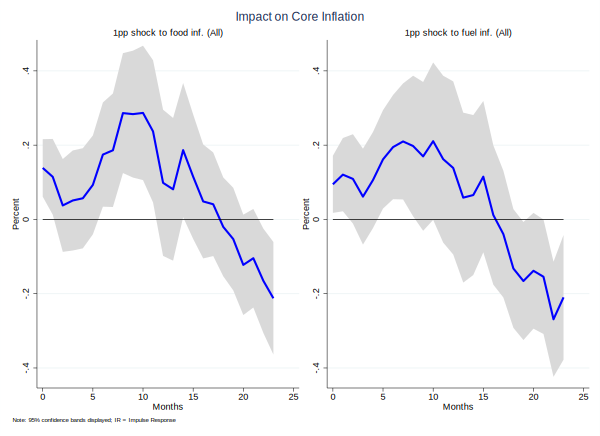

In [10]:
varstable

In [40]:
varlmar


   Lagrange-multiplier test
  +--------------------------------------+
  | lag  |      chi2    df   Prob > chi2 |
  |------+-------------------------------|
  |   1  |   33.1206     9     0.00013   |
  |   2  |   21.7587     9     0.00968   |
  +--------------------------------------+
   H0: no autocorrelation at lag order


In [41]:
vargranger


   Granger causality Wald tests
  +------------------------------------------------------------------+
  |          Equation           Excluded |   chi2     df Prob > chi2 |
  |--------------------------------------+---------------------------|
  |            picore             pifood |  57.217    12    0.000    |
  |            picore             pifuel |  37.681    12    0.000    |
  |            picore                ALL |  79.616    24    0.000    |
  |--------------------------------------+---------------------------|
  |            pifood             picore |  79.921    12    0.000    |
  |            pifood             pifuel |  42.751    12    0.000    |
  |            pifood                ALL |  117.14    24    0.000    |
  |--------------------------------------+---------------------------|
  |            pifuel             picore |   18.54    12    0.100    |
  |            pifuel             pifood |  7.3434    12    0.834    |
  |            pifuel                ALL |  


(file irf.irf now active)

(file myirf2.irf now active)
(file myirf2.irf updated)


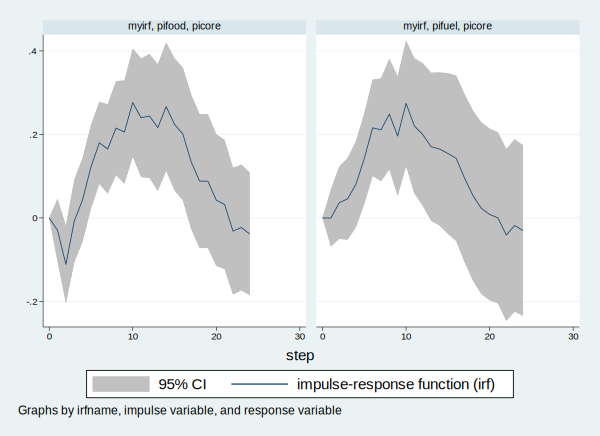





                               Results from myirf

+--------------------------------------------+
|        |    (1)         (1)         (1)    |
|  step  |   irf        Lower       Upper    |
|--------+-----------------------------------|
|0       | 0           0           0         |
|1       | -.02972     -.104823    .045383   |
|2       | -.111434    -.204113    -.018755  |
|3       | -.007712    -.106383    .09096    |
|4       | .043776     -.056178    .14373    |
|5       | .122533     .02278      .222286   |
|6       | .179903     .081433     .278373   |
|7       | .165057     .05811      .272004   |
|8       | .2152       .102649     .327751   |
|9       | .205712     .082158     .329266   |
|10      | .276427     .146991     .405863   |
|11      | .239757     .097889     .381625   |
|12      | .244253     .095835     .392672   |
|13      | .216154     .06463      .367678   |
|14      | .266588     .112937     .420239   |
|15      | .224074     .066055     .382093   |
|16  

In [11]:
irf set irf
irf create myirf, step(24) set(myirf2) replace 
// irf graph irf, irf(irf1)
irf graph irf, impulse(pifood pifuel) response(picore)
irf table irf, impulse(pifood pifuel) response(picore)